# Advanced Machine Learning Models in Finance

## Investigating advanced classifiers

### Getting Ready

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import (train_test_split, StratifiedKFold, RandomizedSearchCV, 
                                     cross_val_score, RandomizedSearchCV, StratifiedKFold)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample
from chapter_9_utils import performance_evaluation_report

import pickle
from pandas import json_normalize

# Provide the absolute path to the file
trials_path = r"C:\Users\USER\trials_final.p"


# Check if the file exists
if not os.path.exists(trials_path):
    raise FileNotFoundError(f"The file {trials_path} does not exist.")

# Load trials
trials = pickle.load(open(trials_path, "rb"))

# Set plotting style and configurations
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\USER\AppData\Local\Temp\ipykernel_27168\317280249.py:47: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


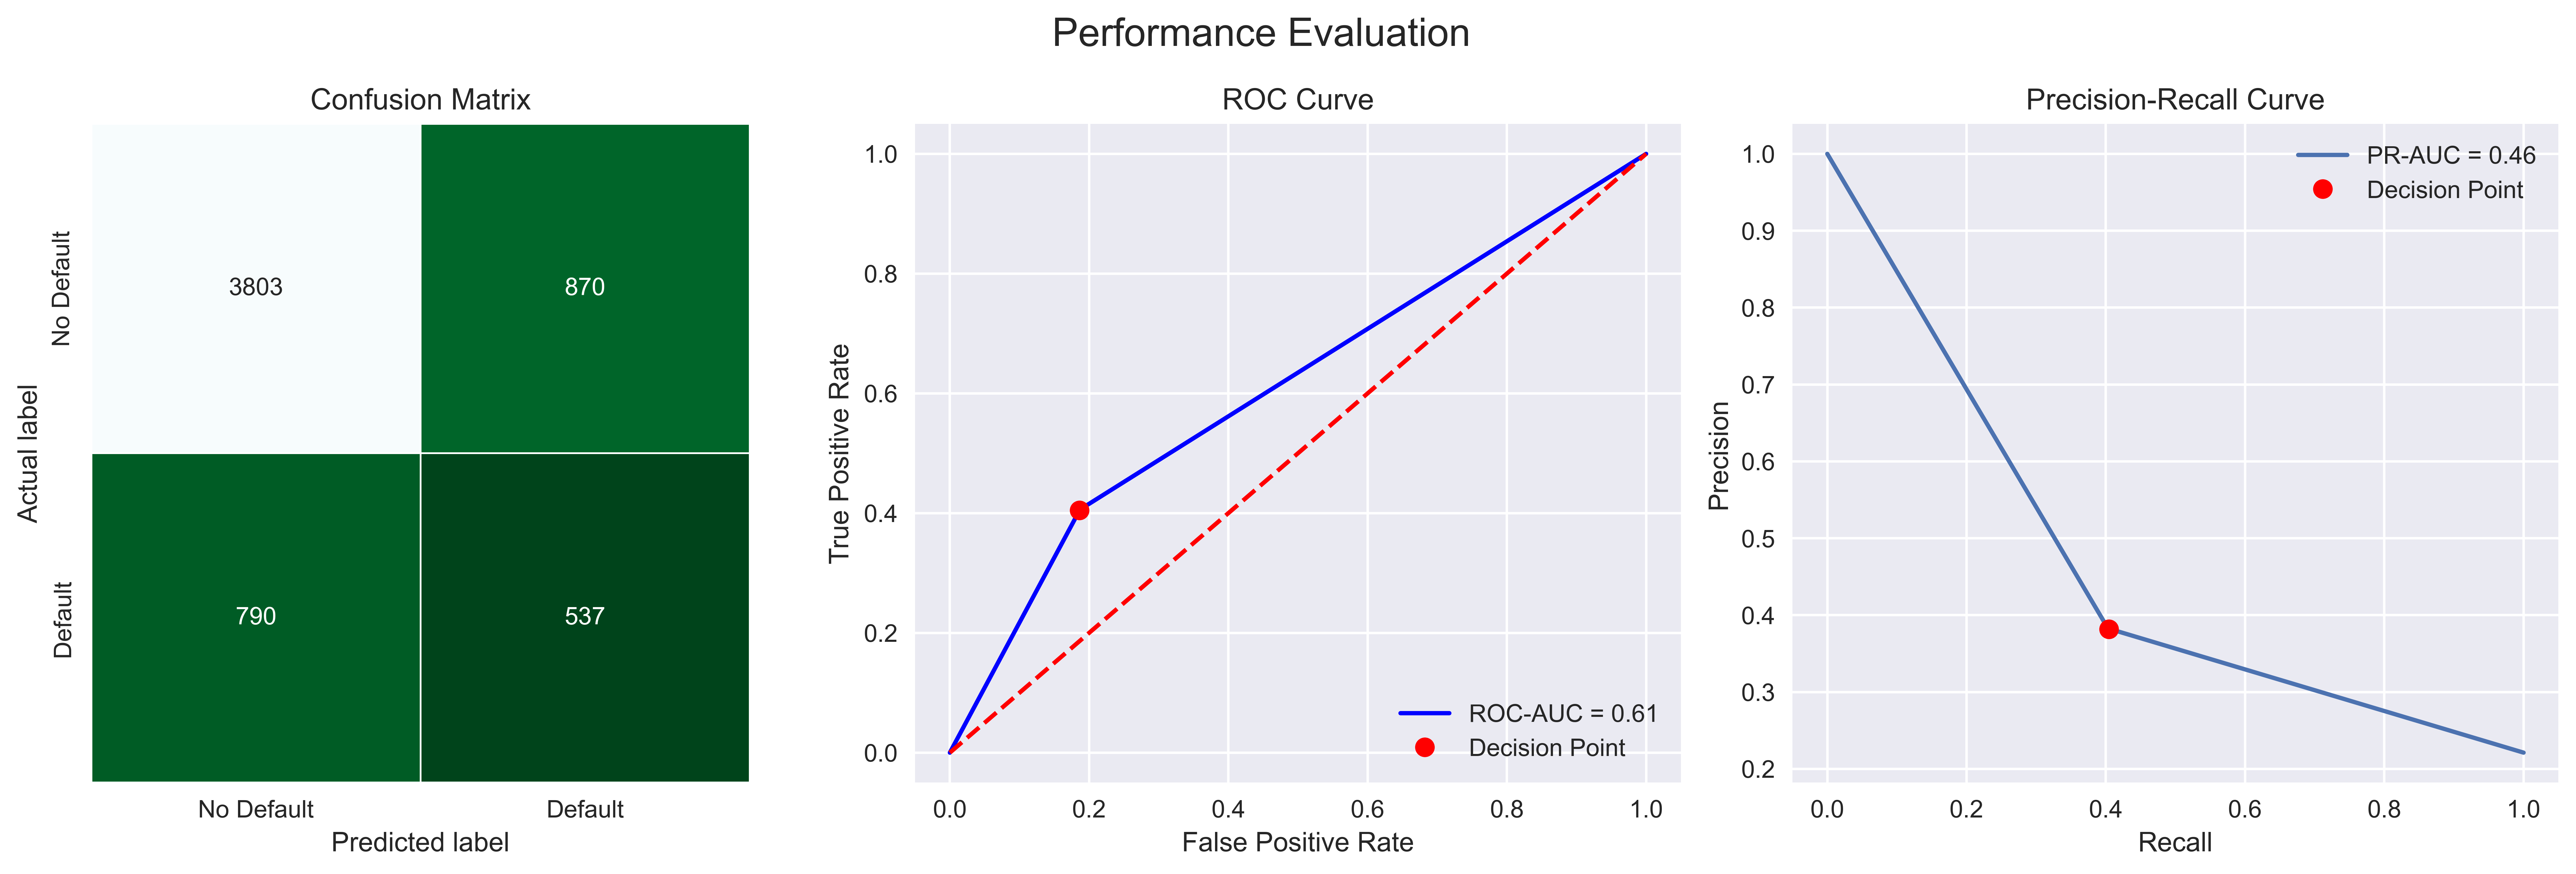

In [2]:
# Load the dataset
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')

# Split the dataset into features (X) and target (y)
X = df.copy()
y = X.pop('default_payment_next_month')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# Identify numerical and categorical features
num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

# Create a numerical preprocessing pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Impute missing values with the median
])

# Create a list of unique categories for each categorical feature
cat_list = [list(X_train[column].dropna().unique()) for column in cat_features]

# Create a categorical preprocessing pipeline
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, 
                             handle_unknown='error', drop='first'))
])

# Combine numerical and categorical pipelines into a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)
], remainder='drop')

# Create a pipeline that includes the preprocessor and the classifier
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline on the training data
tree_pipeline.fit(X_train, y_train)

# Define the labels for the classification report and confusion matrix
LABELS = ['No Default', 'Default']

# Evaluate the performance of the decision tree classifier on the test data
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True, 
                                          show_pr_curve=True)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Display the plots
plt.show()

In [3]:
tree_perf

{'accuracy': 0.7233333333333334,
 'precision': 0.3816631130063966,
 'recall': 0.4046721929163527,
 'specificity': 0.8138240958698909,
 'f1_score': 0.3928310168251646,
 'cohens_kappa': 0.21388003714653614,
 'roc_auc': 0.6095279347712678,
 'pr_auc': 0.4589251149708047}

In [4]:
# investigate the depth of the tree
tree_classifier = tree_pipeline.named_steps['classifier']
tree_classifier.tree_.max_depth

37

2. Create a Random Forest Pipeline:

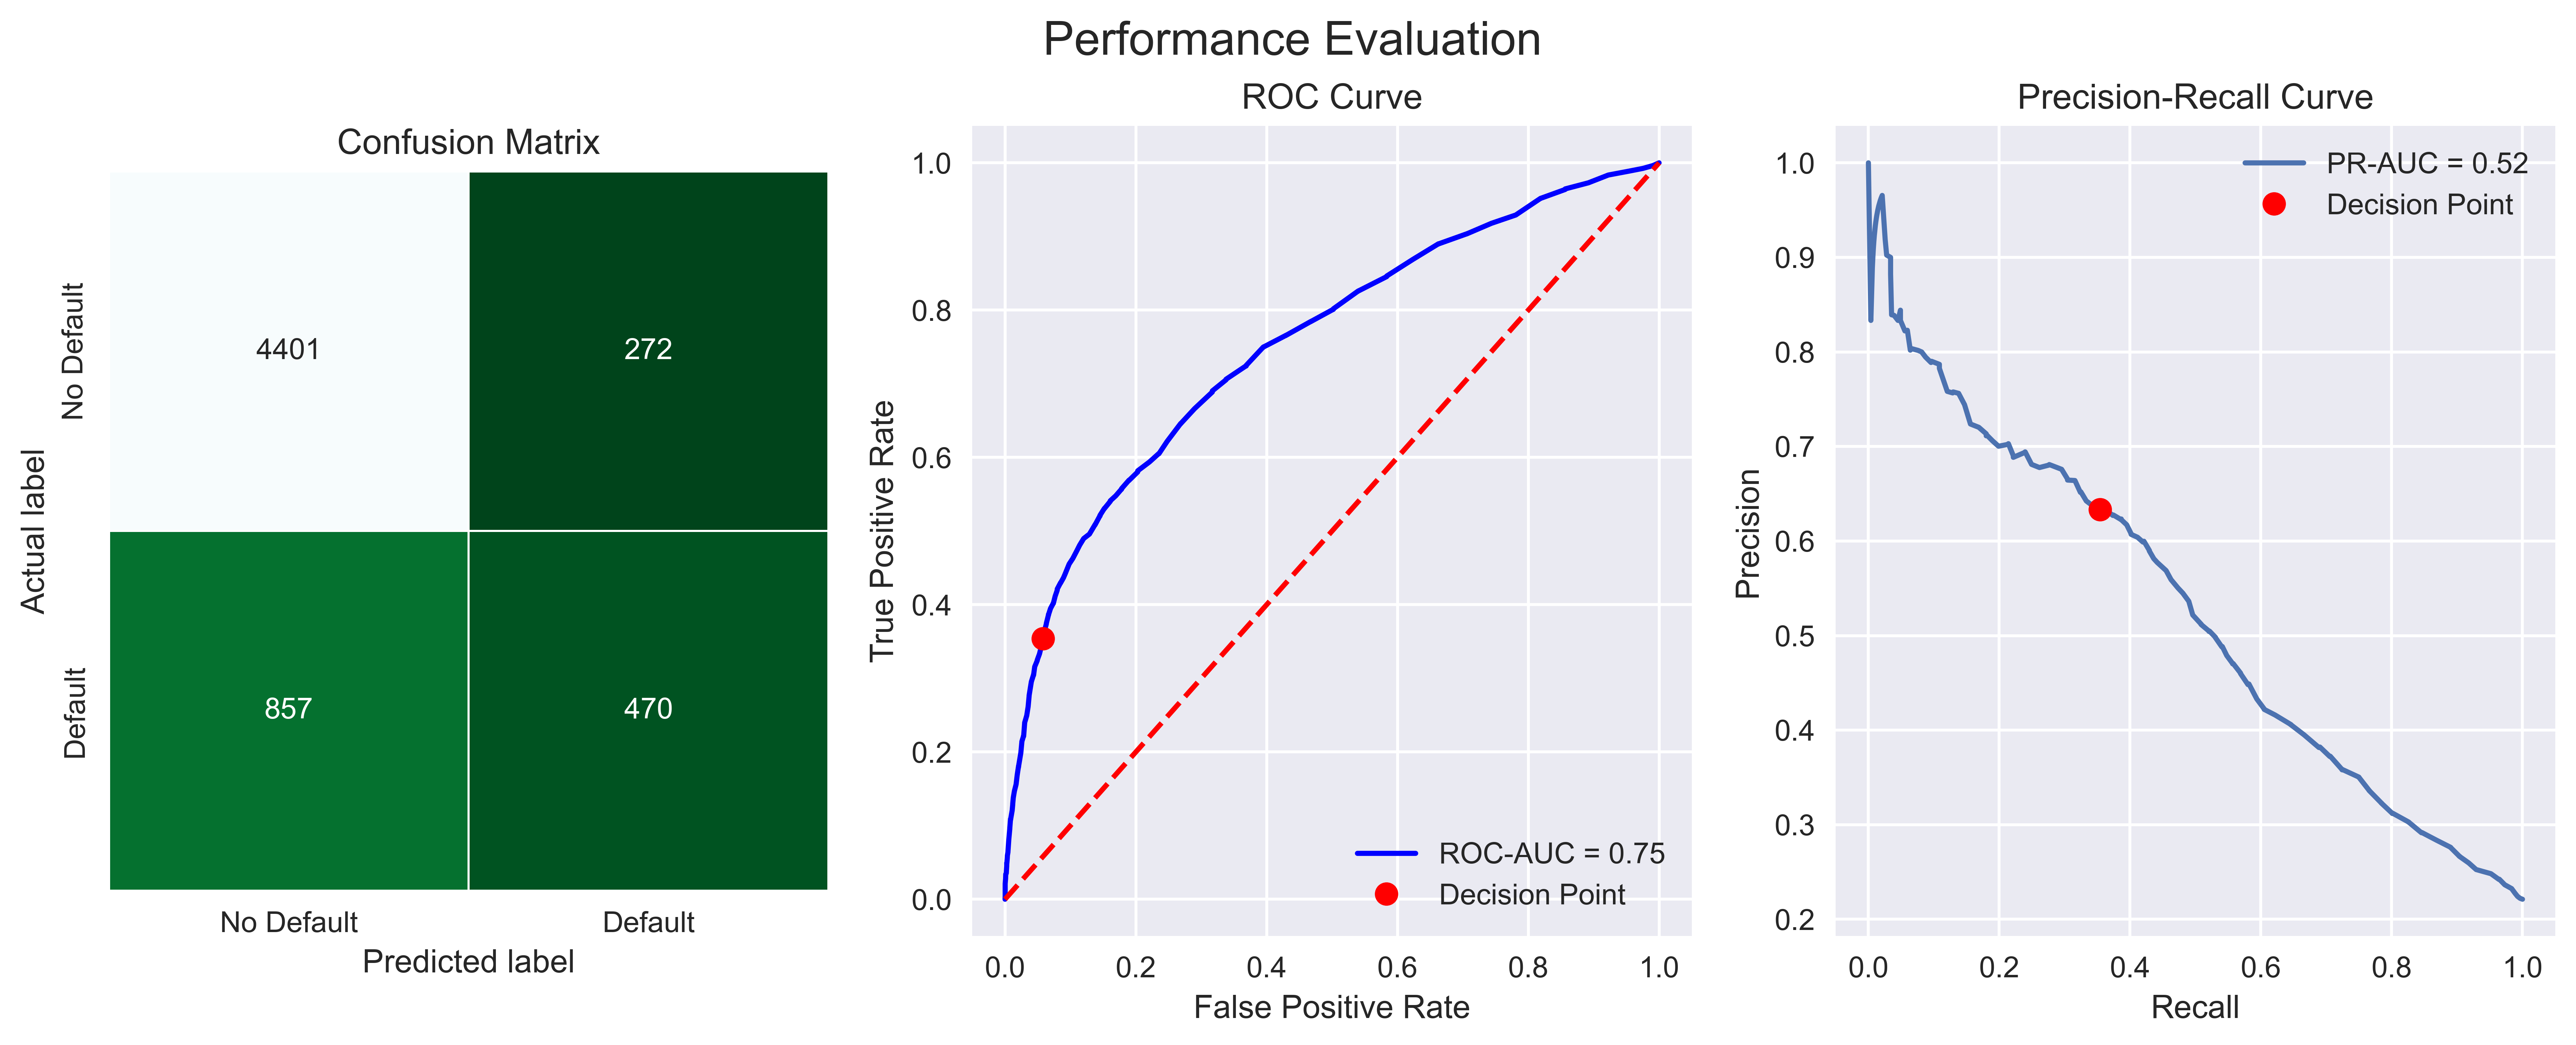

In [5]:
# Initialize a RandomForestClassifier with a fixed random state for reproducibility
rf = RandomForestClassifier(random_state=42)

# Create a pipeline that includes the preprocessor and the RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Fit the pipeline on the training data
rf_pipeline.fit(X_train, y_train)

# Evaluate the performance of the random forest classifier on the test data
rf_perf = performance_evaluation_report(rf_pipeline, X_test, 
                                        y_test, labels=LABELS, 
                                        show_plot=True, 
                                        show_pr_curve=True)

# Display the plots
plt.show()

3. Create a Gradient Boosting Trees Pipeline:

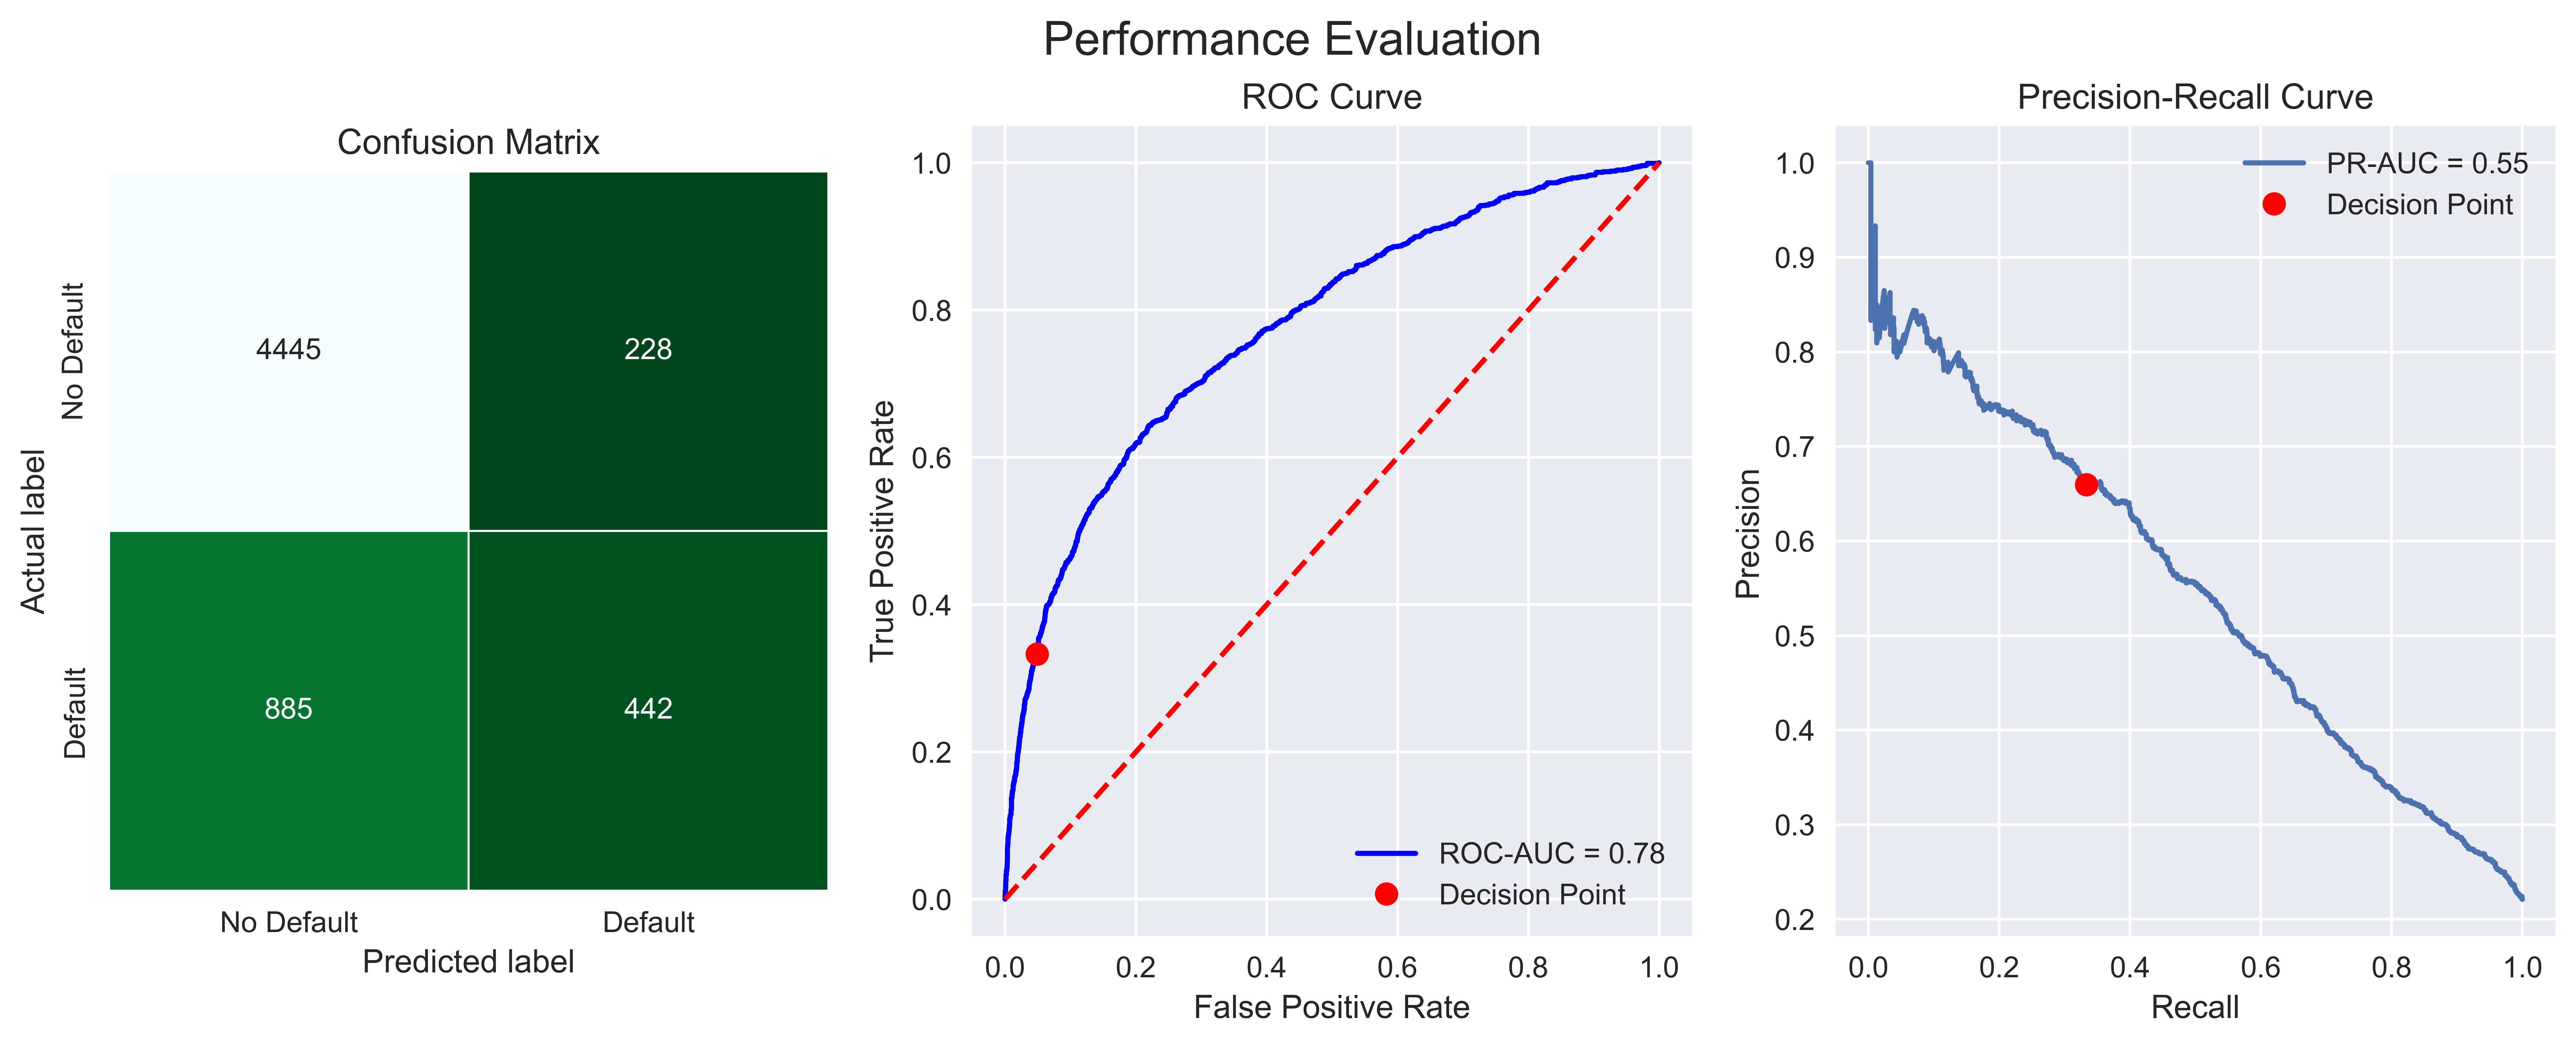

In [6]:
# Initialize a GradientBoostingClassifier with a fixed random state for reproducibility
gbt = GradientBoostingClassifier(random_state=42)

# Create a pipeline that includes the preprocessor and the GradientBoostingClassifier
gbt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', gbt)
])

# Fit the pipeline on the training data
gbt_pipeline.fit(X_train, y_train)

# Evaluate the performance of the gradient boosting classifier on the test data
gbt_perf = performance_evaluation_report(gbt_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True, 
                                         show_pr_curve=True)

# Display the plots
plt.show()

4. Create a xgBoost Pipeline:

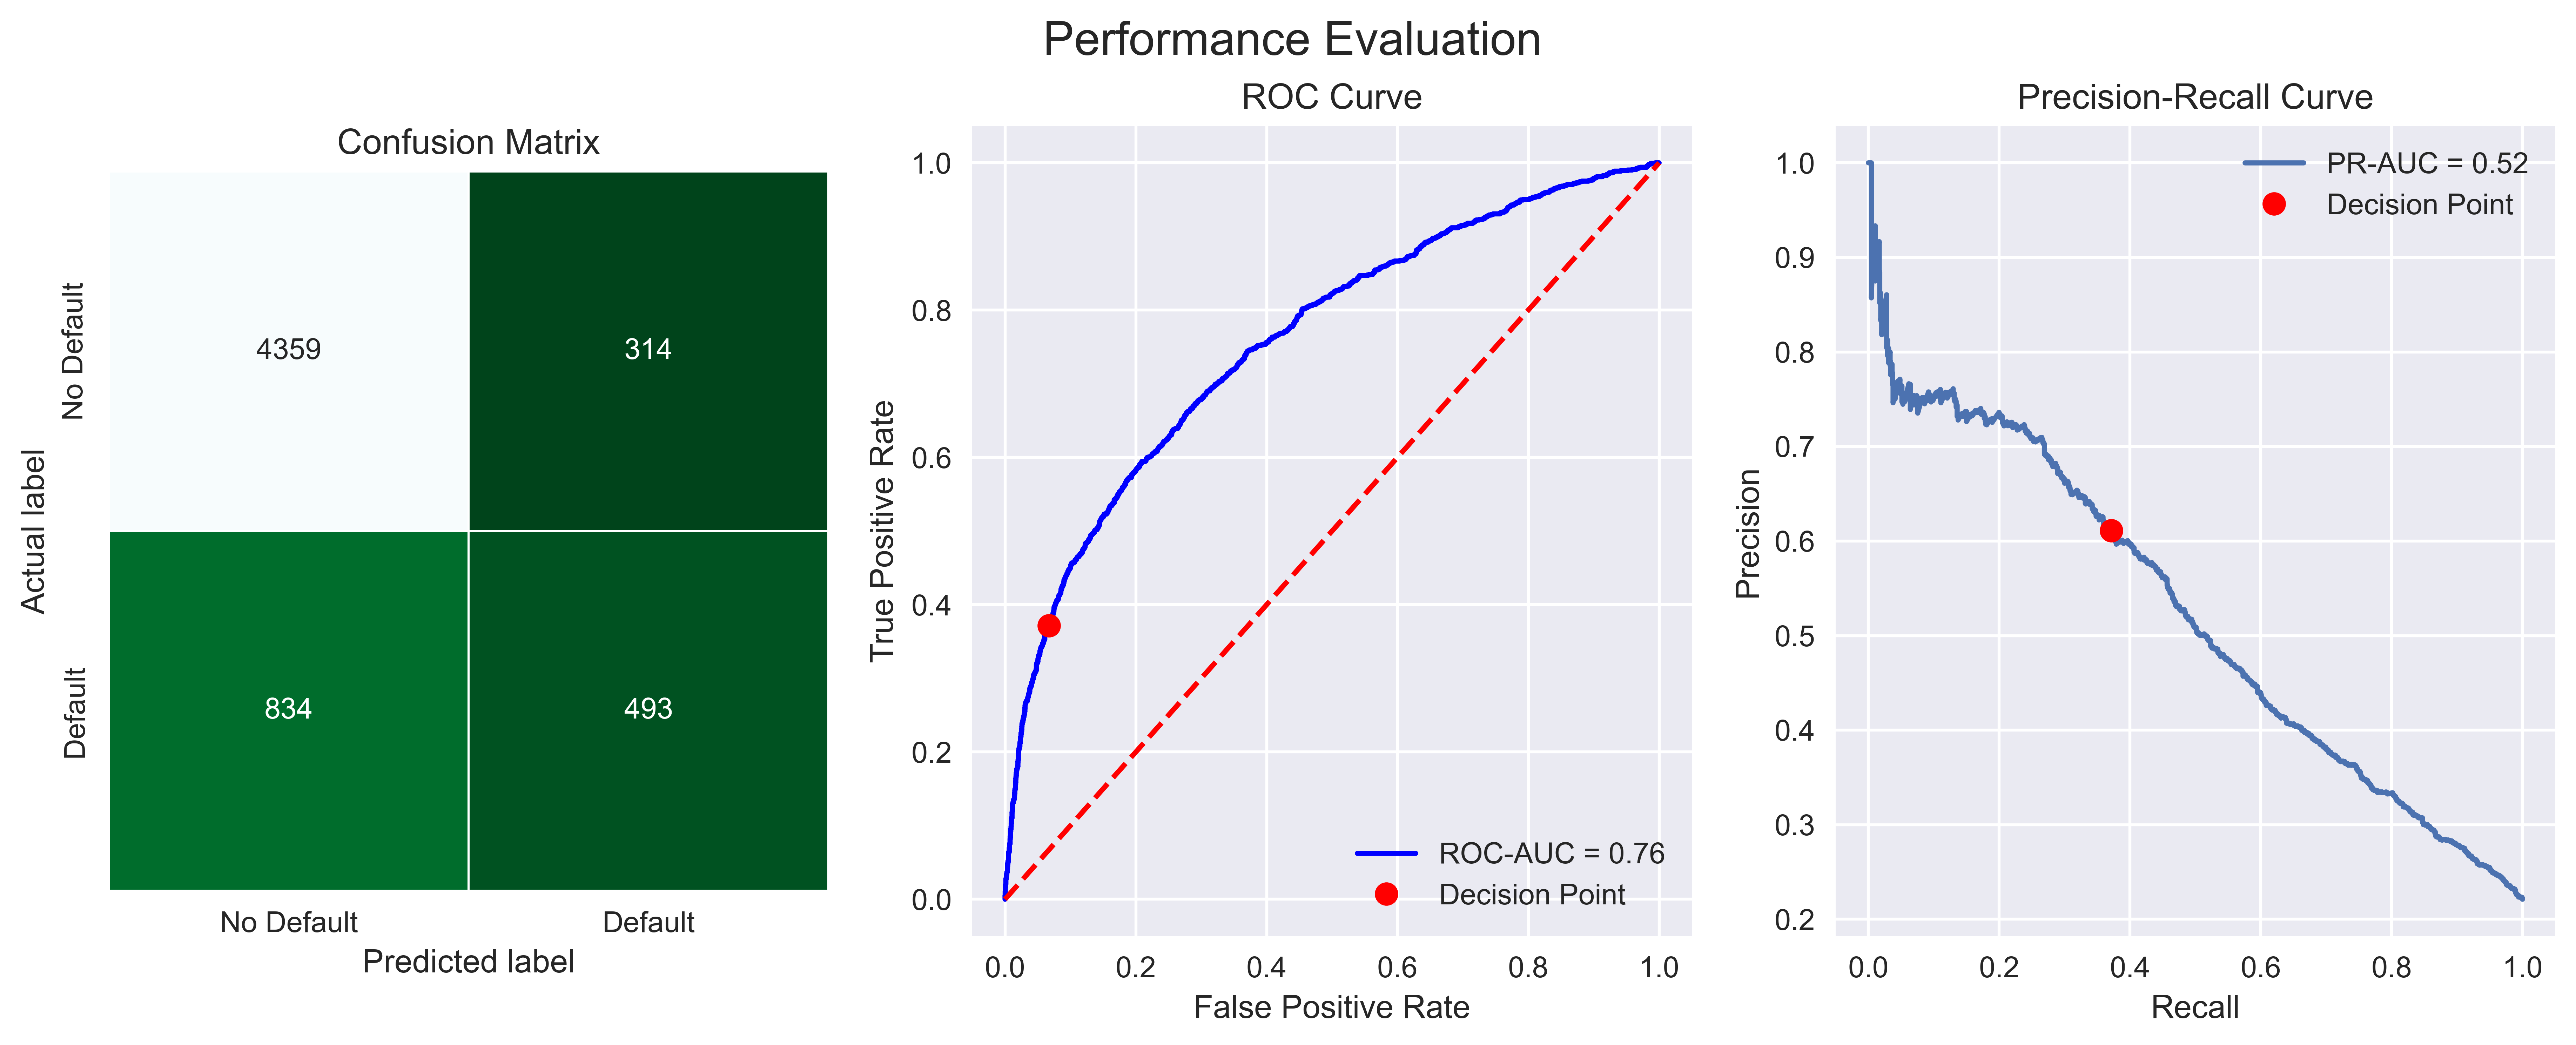

In [7]:
# Initialize an XGBClassifier with a fixed random state for reproducibility
xgb = XGBClassifier(random_state=42)

# Create a pipeline that includes the preprocessor and the XGBClassifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Fit the pipeline on the training data
xgb_pipeline.fit(X_train, y_train)

# Evaluate the performance of the XGBoost classifier on the test data
xgb_perf = performance_evaluation_report(xgb_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True, 
                                         show_pr_curve=True)

# Display the plots
plt.show()

5. Create a LightGBM classifier Pipeline:

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639


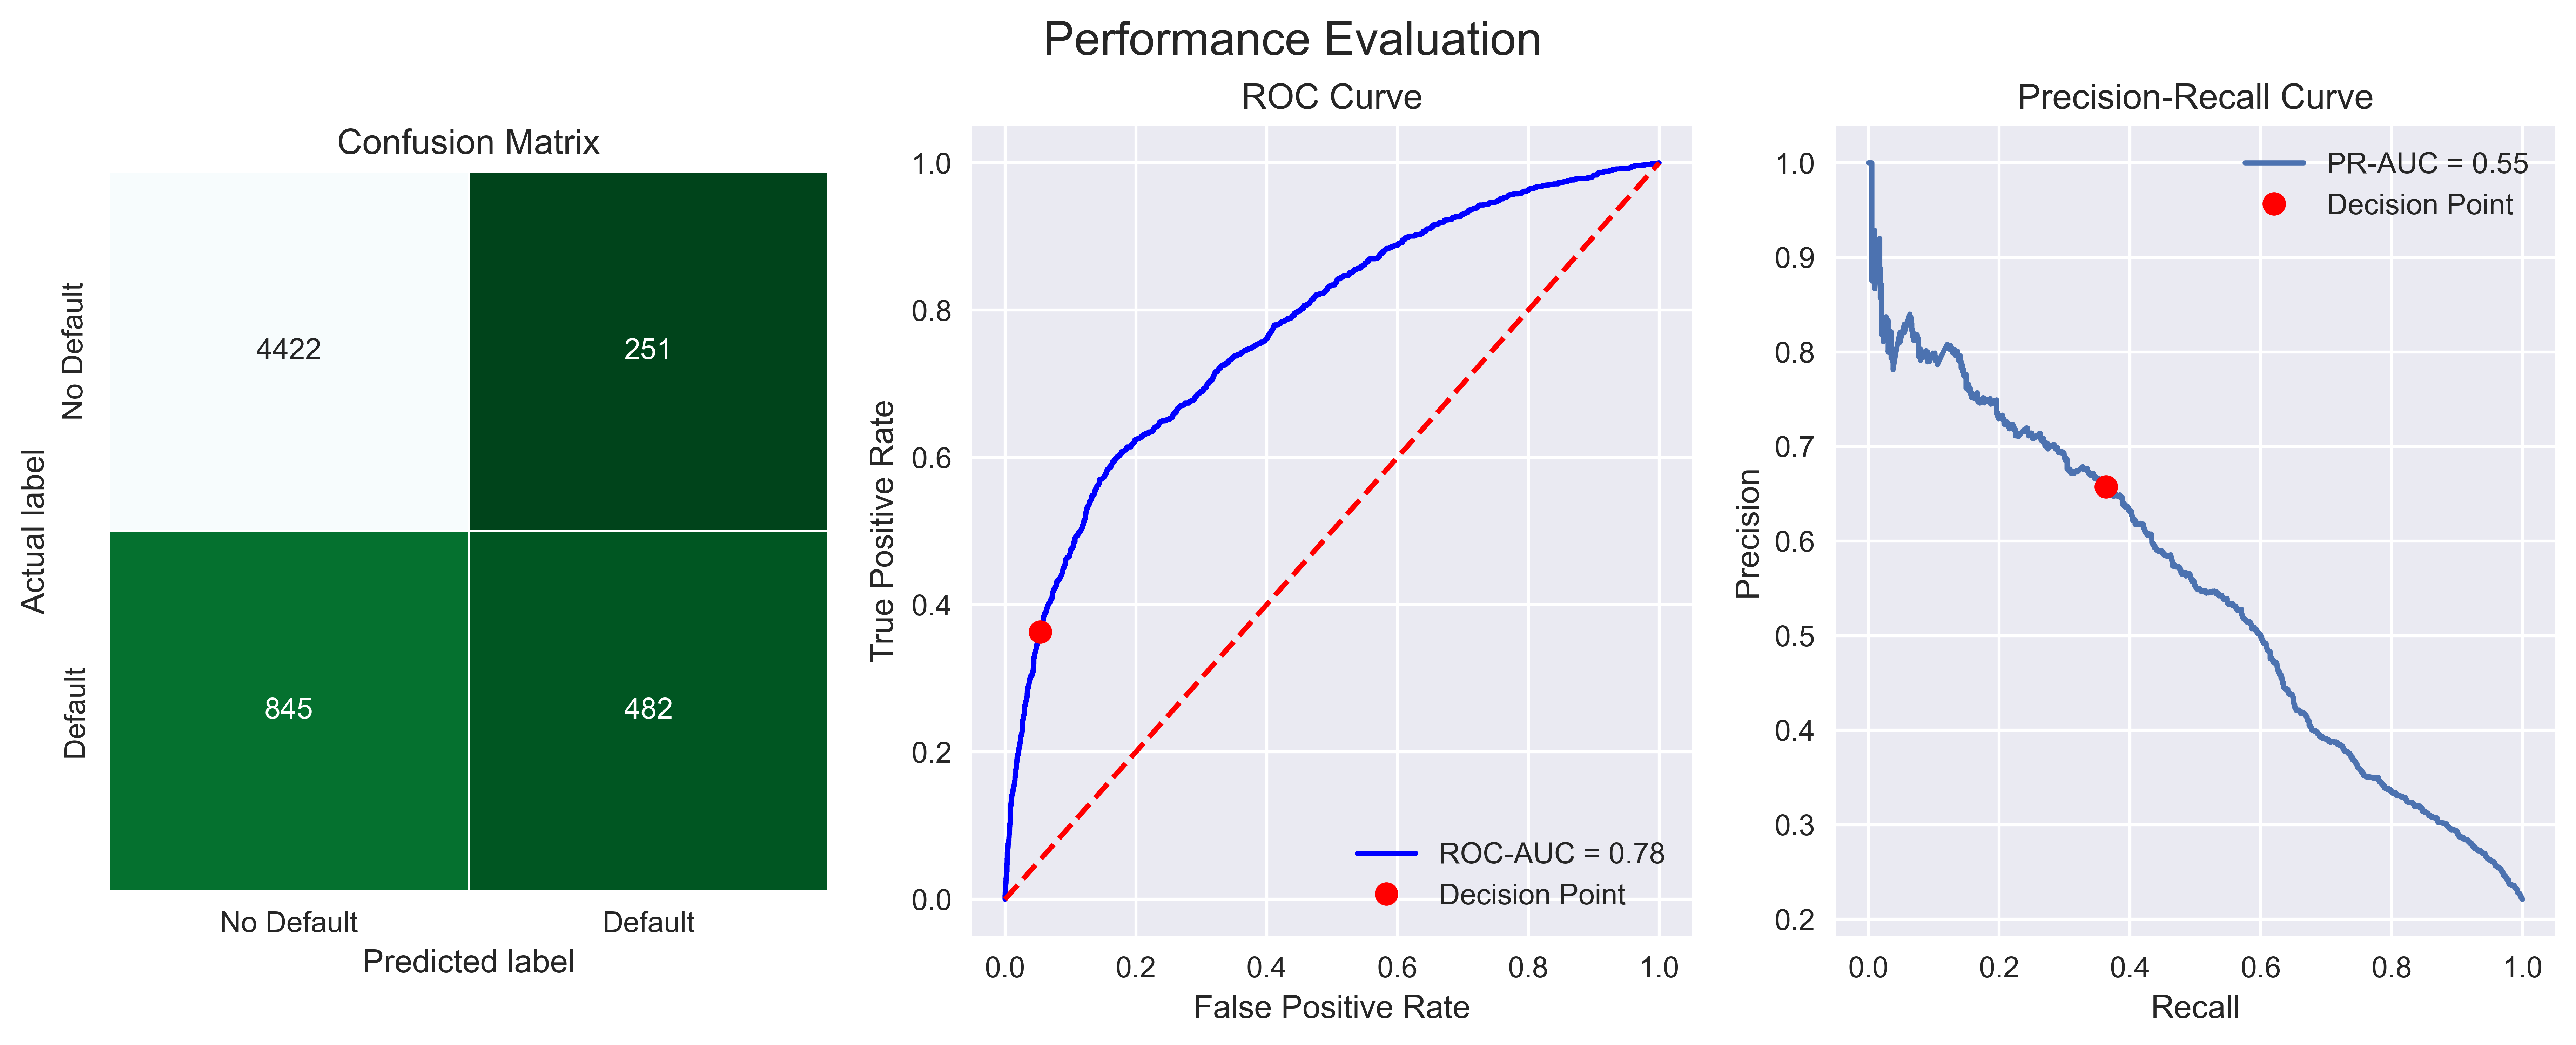

In [8]:
# Initialize an LGBMClassifier with a fixed random state for reproducibility
lgbm = LGBMClassifier(random_state=42)

# Create a pipeline that includes the preprocessor and the LGBMClassifier
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessing steps defined earlier
    ('classifier', lgbm)             # Apply the LGBMClassifier
])

# Fit the pipeline on the training data
lgbm_pipeline.fit(X_train, y_train)

# Evaluate the performance of the LightGBM classifier on the test data
lgbm_perf = performance_evaluation_report(lgbm_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True, 
                                          show_pr_curve=True)

# Display the plots
plt.show()

### There's more about use advanced classifiers to achieve better results

Below we go over the most important hyperparameters of the considered models and show a possible way of tuning them using Randomized Search. With more complex models, the training time is significantly longer than with the basic Decision Tree, so we need to find a balance between the time we want to spend on tuning the hyperparameters and the expected results. Also, bear in mind that changing the values of some parameters (such as learning rate or the number of estimators) can itself influence the training time of the models.

To have the results in a reasonable amount of time, we used the Randomized Search with 100 different sets of hyperparameters for each model (the number of actually fitted models is higher due to cross-validation). Just as in the recipe *Grid Search and Cross-Validation*, we used recall as the criterion for selecting the best model. Additionally, we used the scikit-learn compatible APIs of XGBoost and LightGBM to make the process as easy to follow as possible. For a complete list of hyperparameters and their meaning, please refer to corresponding documentations.

In [10]:
# Define cross-validation strategy
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Number of parameter settings that are sampled
N_SEARCHES = 100

**Random Forest**

When tuning the Random Forest classifier, we look at the following hyperparameters (there are more available for tuning):
* `n_estimators` - the number of decision trees in a forest. The goal is to find a balance between improved accuracy and computational cost.
* `max_features` - the maximum number of features considered for splitting a node. The default is the square root of the number of features. When None, all features are considered.
* `max_depth` - the maximum number of levels in each decision tree
* `min_samples_split` - the minimum number of observations required to split each node. When set to high it may cause underfitting, as the trees will not split enough times.
* `min_samples_leaf` - the minimum number of data points allowed in a leaf. Too small a value might cause overfitting, while large values might prevent the tree from growing and cause underfitting.
* `bootstrap` - whether to use bootstrapping for each tree in the forest
    
    We define the grid below:

In [ ]:
# Define the parameter grid for the RandomForestClassifier
rf_param_grid = {
    'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'classifier__max_features': ['log2', 'sqrt', None],
    'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': np.arange(1, 51, 2, dtype=int),
    'classifier__bootstrap': [True, False]
}

# Initialize the RandomizedSearchCV with the RandomForestClassifier pipeline
rf_rs = RandomizedSearchCV(rf_pipeline, rf_param_grid, scoring='recall', 
                           cv=k_fold, n_jobs=-1, verbose=1, 
                           n_iter=N_SEARCHES, random_state=42)

# Fit the RandomizedSearchCV on the training data
rf_rs.fit(X_train, y_train)

# Print the best parameters and recall scores
print(f'Best parameters: {rf_rs.best_params_}') 
print(f'Recall (Training set): {rf_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, rf_rs.predict(X_test)):.4f}')

In [ ]:
rf_rs_perf = performance_evaluation_report(rf_rs, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True,
                                          show_pr_curve=True)

**Gradient Boosted Trees**

As Gradient Boosted Trees are also an ensemble method built on top of decision trees, a lot of the parameters are the same as in the case of the Random Forest. The new one is the learning rate, which is used in the gradient descent algorithm to control the rate of descent towards the minimum of the loss function. When tuning the tree manually, we should consider this hyperparameter together with the number of estimators, as reducing the learning rate (the learning is slower), while increasing the number of estimators can increase the computation time significantly.

We define the grid as follows:

In [ ]:
# Define the parameter grid for the GradientBoostingClassifier
gbt_param_grid = {
    'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
    'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
    'classifier__min_samples_split': np.linspace(0.1, 0.5, 12),
    'classifier__min_samples_leaf': np.arange(1, 51, 2, dtype=int),
    'classifier__max_features': ['log2', 'sqrt', None]
}

# Initialize the RandomizedSearchCV with the GradientBoostingClassifier pipeline
gbt_rs = RandomizedSearchCV(gbt_pipeline, gbt_param_grid, scoring='recall', 
                            cv=k_fold, n_jobs=-1, verbose=1, 
                            n_iter=N_SEARCHES, random_state=42)

# Fit the RandomizedSearchCV on the training data
gbt_rs.fit(X_train, y_train)

# Print the best parameters and recall scores
print(f'Best parameters: {gbt_rs.best_params_}') 
print(f'Recall (Training set): {gbt_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, gbt_rs.predict(X_test)):.4f}')

In [ ]:
gbt_rs_perf = performance_evaluation_report(gbt_rs, X_test, 
                                           y_test, labels=LABELS, 
                                           show_plot=True,
                                           show_pr_curve=True)

In [ ]:
# Function to evaluate model performance
def performance_evaluation_report(model, X_test, y_test, labels=None, show_plot=True):
    """
    Evaluates the performance of a classification model on the test data.
    
    Parameters
    ----------
    model : sklearn classifier
        The trained classifier to evaluate.
    X_test : pd.DataFrame or np.ndarray
        The test features.
    y_test : pd.Series or np.ndarray
        The true labels for the test data.
    labels : list, optional
        List of label names for the classification report.
    show_plot : bool, optional
        Whether to display the confusion matrix and ROC curve plots.
        
    Returns
    -------
    report : dict
        A dictionary containing the classification report.
    """
    # Predict the test data
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Generate the classification report
    report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
    
    if show_plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax[0])
        ax[0].set_xlabel('Predicted Labels')
        ax[0].set_ylabel('True Labels')
        ax[0].set_title('Confusion Matrix')
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.05])
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
        ax[1].legend(loc='lower right')
        
        plt.tight_layout()
        plt.show()
    
    return report

# Define labels for the classification report
LABELS = ['No Default', 'Default']

# Evaluate the performance of the decision tree pipeline on the test data
gbt_rs_perf = performance_evaluation_report(gbt_rs, X_test, 
                                           y_test, labels=LABELS, 
                                           show_plot=True,
                                           show_pr_curve=True)

plt.tight_layout()
plt.show()

**XGBoost**

The scikit-learn API of XGBoost makes sure that the hyperparameters are named similarly to their equivalents other scikit-learn's classifiers. So the XGBoost native eta hyperparameter is called learning_rate in scikit-learn's API. 

The new hyperparameters we consider for this example are:
* `min_child_weight` - indicates the minimum sum of weights of all observations required in a child. This hyperparameter is used for controlling overfitting. Cross-validation should be used for tuning.
* `colsample_bytree` - indicates the fraction of columns to be randomly sampled for each tree.
    
    We define the grid as:

In [ ]:
# Define the parameter grid for the XGBClassifier
xgb_param_grid = {
    'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
    'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
    'classifier__min_child_weight': np.arange(1, 8, 1, dtype=int),
    'classifier__colsample_bytree': np.linspace(0.3, 1, 7)
}

# Initialize the RandomizedSearchCV with the XGBClassifier pipeline
xgb_rs = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring='recall', 
                            cv=k_fold, n_jobs=-1, verbose=1, 
                            n_iter=N_SEARCHES, random_state=42)

# Fit the RandomizedSearchCV on the training data
xgb_rs.fit(X_train, y_train)

# Print the best parameters and recall scores
print(f'Best parameters: {xgb_rs.best_params_}') 
print(f'Recall (Training set): {xgb_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, xgb_rs.predict(X_test)):.4f}')

For defining ranges of parameters that are restricted (such as colsample_bytree which cannot be higher than 1.0) it is better to use `np.linspace` rather than `np.arange`, because the latter allows for some inconsistencies when the step is defined as floating-point. For example, the last value might be 1.0000000002, which then causes an error while training the classifier.

In [ ]:
xgb_rs_perf = performance_evaluation_report(xgb_rs, X_test, 
                                           y_test, labels=LABELS, 
                                           show_plot=True,
                                           show_pr_curve=True)

**LightGBM**

We tune the same parameters as in XGBoost, though more is definitely possible and encouraged. The grid is defined as follows:

In [ ]:
# Define the parameter grid for the LGBMClassifier
lgbm_param_grid = {
    'classifier__n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'classifier__learning_rate': np.arange(0.05, 0.31, 0.05),
    'classifier__max_depth': np.arange(3, 11, 1, dtype=int),
    'classifier__colsample_bytree': np.linspace(0.3, 1, 7)
}

# Initialize the RandomizedSearchCV with the LGBMClassifier pipeline
lgbm_rs = RandomizedSearchCV(lgbm_pipeline, lgbm_param_grid, scoring='recall', 
                             cv=k_fold, n_jobs=-1, verbose=1, 
                             n_iter=N_SEARCHES, random_state=42)

# Fit the RandomizedSearchCV on the training data
lgbm_rs.fit(X_train, y_train)

# Print the best parameters and recall scores
print(f'Best parameters: {lgbm_rs.best_params_}') 
print(f'Recall (Training set): {lgbm_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, lgbm_rs.predict(X_test)):.4f}')

In [ ]:
lgbm_rs_perf = performance_evaluation_report(lgbm_rs, X_test, 
                                            y_test, labels=LABELS, 
                                            show_plot=True,
                                            show_pr_curve=True)

Below we present a summary of all the classifiers we have considered in the last 3 recipes.

In [ ]:
# Create a dictionary to store the performance metrics of each model
results_dict = {
    'decision_tree_baseline': tree_perf,
    'random_forest': rf_perf,
    'random_forest_rs': rf_rs_perf,
    'gradient_boosted_trees': gbt_perf,
    'gradient_boosted_trees_rs': gbt_rs_perf,
    'xgboost': xgb_perf,
    'xgboost_rs': xgb_rs_perf,
    'light_gbm': lgbm_perf,
    'light_gbm_rs': lgbm_rs_perf
}

# Convert the results dictionary into a DataFrame for easier comparison
results_comparison = pd.DataFrame(results_dict).T

# Display the comparison DataFrame
results_comparison

In [ ]:
# Read the results_comparison DataFrame from a CSV file
results_comparison = pd.read_csv('results_comparison.csv')

# Rename the 'Unnamed: 0' column to 'model'
results_comparison.rename(columns={'Unnamed: 0': 'model'}, inplace=True)

# Display the DataFrame
results_comparison

## Using stacking for improved performance

2. Load and preprocess data:

In [ ]:
# Set a fixed random state for reproducibility
RANDOM_STATE = 42

# Define the cross-validation strategy
k_fold = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)

# Load the dataset
df = pd.read_csv('credit_card_fraud.csv')

# Split the dataset into features (X) and target (y)
X = df.copy()
y = X.pop('Class')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,  # Use 20% of the data for testing
                                                    stratify=y,  # Stratify to preserve class distribution
                                                    random_state=RANDOM_STATE)  # Ensure reproducibility

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the training data
X_train = scaler.fit_transform(X_train)

# Scale the testing data
X_test = scaler.transform(X_test)

3. Define a list of classifiers to consider:

In [ ]:
# Define a list of classifiers to evaluate
clf_list = [
    ('dec_tree', DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ('log_reg', LogisticRegression(random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier()),
    ('naive_bayes', GaussianNB())
]

# Loop through the list of classifiers
for model_name, model in clf_list:
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict the labels for the test data
    y_pred = model.predict(X_test)
    
    # Calculate the recall score
    recall = metrics.recall_score(y_test, y_pred)
    
    # Print the recall score for the current model
    print(f"{model_name}'s recall score: {recall:.4f}")

5. Define and fit the stacking classifier:

In [ ]:
lr = LogisticRegression()
stack_clf = StackingClassifier(clf_list, 
                              final_estimator=lr,
                              cv=k_fold,
                              n_jobs=-1)
stack_clf.fit(X_train, y_train)

6. Create predictions and evaluate the stacked ensemble:

In [ ]:
y_pred = stack_clf.predict(X_test)
recall = metrics.recall_score(y_pred, y_test)
print(f"The stacked ensemble's recall score: {recall:.4f}")

## Investigating the feature importance

2. Extract the classifier and preprocessor from the pipeline:

In [ ]:
# in case we have the fitted grid search object `rf_rs`, we extract the best pipeline
# rf_pipeline = rf_rs.best_estimator_

rf_classifier = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessor']

# in case we want to manually assign hyperparameters based on previous grid search
# best_parameters =  {'n_estimators': 400, 'min_samples_split': 2, 
#                     'min_samples_leaf': 49, 'max_features': None, 
#                     'max_depth': 20, 'bootstrap': True, 'random_state': 42}
# rf_classifier = rf_classifier.set_params(**best_parameters)

3. Recover feature names from the preprocessing transformer and transform the training data:

In [ ]:
# Extract the feature names for the categorical features after one-hot encoding
feat_names = preprocessor.named_transformers_['categorical'] \
                         .named_steps['onehot'] \
                         .get_feature_names_out(input_features=cat_features)

# Concatenate numerical feature names with one-hot encoded categorical feature names
feat_names = np.r_[num_features, feat_names]

# Transform the training data using the preprocessor and convert to a DataFrame with proper column names
X_train_preprocessed = pd.DataFrame(
    preprocessor.transform(X_train), 
    columns=feat_names
)

# Transform the test data using the preprocessor and convert to a DataFrame with proper column names (optional)
X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test), 
    columns=feat_names
)

# Display the preprocessed training data
X_train_preprocessed.head()

4. Extract the default feature importance and calculate the cumulative importance:

In [ ]:
rf_feat_imp = pd.DataFrame(rf_classifier.feature_importances_,
                          index=feat_names,
                          columns=['mdi'])
rf_feat_imp = rf_feat_imp.sort_values('mdi', ascending=False)
rf_feat_imp['cumul_importance_mdi'] = np.cumsum(rf_feat_imp.mdi)

5. Define a function for plotting top X features in terms of their importance:

In [ ]:
def plot_most_important_features(feat_imp, method='MDI', 
                                n_features=10, bottom=False):
    '''
    Function for plotting the top/bottom x features in terms of their importance.
    
    Parameters
    ----------
    feat_imp : pd.Series
        A pd.Series with calculated feature importances.
    method : str
        A string representing the method of calculating the importances.
        Used for the title of the plot.
    n_features : int
        Number of top/bottom features to plot.
    bottom : boolean
        Indicates if the plot should contain the bottom feature importances.
    
    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot
        Axes object containing the plot.
    '''
    
    # Sort feature importances
    if bottom:
        indicator = 'Bottom'
        feat_imp = feat_imp.sort_values(ascending=True)
    else:
        indicator = 'Top'
        feat_imp = feat_imp.sort_values(ascending=False)
    
    # Plot the feature importances
    ax = feat_imp.head(n_features).plot.barh()
    ax.invert_yaxis()  # Ensure the most important feature is at the top
    
    # Set plot title and labels
    ax.set(title=f'Feature importance - {method} ({indicator} {n_features})', 
           xlabel='Importance', 
           ylabel='Feature')
            
    return ax

In [ ]:
plot_most_important_features(rf_feat_imp.mdi, 
                            method='MDI')

plt.tight_layout()
plt.show()

6. Plot the cumulative importance of the features:

In [ ]:
# Define the x values based on the number of features
x_values = range(len(feat_names))

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the cumulative importances
ax.plot(x_values, rf_feat_imp.cumul_importance_mdi, 'b-')

# Add a horizontal line at 0.95 to indicate the 95% cumulative importance threshold
ax.hlines(y=0.95, xmin=0, xmax=len(x_values), color='g', linestyles='dashed')

# Set the title and labels
ax.set(title='Cumulative Importances', 
       xlabel='Variable', 
       ylabel='Importance')

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
print(f'Top 10 features account for {100 * rf_feat_imp.head(10).mdi.sum():.2f}% of the total importance.')
print(f'Top {rf_feat_imp[rf_feat_imp.cumul_importance_mdi <= 0.95].shape[0]} features account for 95% of importance.')

7. Calculate and plot permutation importance:

In [ ]:
perm = PermutationImportance(rf_classifier, n_iter = 25, 
                            random_state=42)
perm.fit(X_train_preprocessed, y_train)
rf_feat_imp['permutation'] = perm.feature_importances_

In [ ]:
plot_most_important_features(rf_feat_imp.permutation, 
                            method='Permutation')

plt.tight_layout()
plt.show()

8. Define a function for calculating the drop-column feature importance:

In [ ]:
def drop_col_feat_imp(model, X, y, random_state=42):
    '''
    Function for calculating the drop column feature importance.
    
    Parameters
    ----------
    model : scikit-learn estimator
        Object representing the estimator with selected hyperparameters.
    X : pd.DataFrame
        Features for training the model.
    y : pd.Series
        The target variable.
    random_state : int, optional (default=42)
        Random state for reproducibility.
    
    Returns
    -------
    importances : list
        List containing the calculated feature importances in the order of appearing in X.
    '''
    
    # Clone the model to ensure it does not affect the original model
    model_clone = clone(model)
    model_clone.random_state = random_state
    
    # Fit the model on the entire dataset
    model_clone.fit(X, y)
    
    # Calculate the benchmark score with all features
    benchmark_score = model_clone.score(X, y)
    
    # Initialize an empty list to store feature importances
    importances = []
    
    # Iterate over each feature to calculate its importance
    for col in X.columns:
        # Clone the model for each iteration
        model_clone = clone(model)
        model_clone.random_state = random_state
        
        # Fit the model on the dataset with the current feature dropped
        model_clone.fit(X.drop(col, axis=1), y)
        
        # Calculate the score with the current feature dropped
        drop_col_score = model_clone.score(X.drop(col, axis=1), y)
        
        # Calculate the importance as the difference between benchmark score and drop column score
        importances.append(benchmark_score - drop_col_score)
        
    return importances

9. Calculate and plot the drop-column feature importance:

In [ ]:
rf_feat_imp['drop_column'] = drop_col_feat_imp(
    rf_classifier, 
    X_train_preprocessed, 
    y_train, 
    random_state = 42
)

In [ ]:
plot_most_important_features(rf_feat_imp.drop_column, 
                            method='Drop column')

plt.tight_layout()
plt.show()

In [ ]:
plot_most_important_features(rf_feat_imp.drop_column, 
                            method='Drop column', 
                            bottom=True)

plt.tight_layout()
plt.show()

## Investigating different approaches to handling imbalanced data

2. Load and prepare data:

In [ ]:
df = pd.read_csv('credit_card_fraud.csv')

X = df.copy()
y = X.pop('Class')

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   stratify=y, 
                                                   random_state=RANDOM_STATE)

In [ ]:
y.value_counts(normalize=True)

3. Train the baseline model:

In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

In [ ]:
rf_perf = performance_evaluation_report(rf, X_test, y_test, 
                                       show_plot=True, 
                                       show_pr_curve=True)

In [ ]:
rf_perf

4. Undersample the data and train a Random Forest Classifier:

In [ ]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_rus))}')

rf.fit(X_rus, y_rus)
rf_rus_perf = performance_evaluation_report(rf, X_test, y_test, 
                                           show_plot=True, 
                                           show_pr_curve=True)

In [ ]:
rf_rus_perf

5. Oversample the data and train a Random Forest Classifier:

In [ ]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_ros))}')

rf.fit(X_ros, y_ros)
rf_ros_perf = performance_evaluation_report(rf, X_test, y_test, 
                                           show_plot=True, 
                                           show_pr_curve=True)

In [ ]:
rf_ros_perf

6. Oversample using SMOTE:

In [ ]:
X_smote, y_smote = SMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_smote))}')
rf.fit(X_smote, y_smote)
rf_smote_perf = performance_evaluation_report(rf, X_test, y_test, 
                                             show_plot=True, 
                                             show_pr_curve=True)

In [ ]:
rf_smote_perf

7. Oversample using ADASYN:

In [ ]:
X_adasyn, y_adasyn = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print(f'The new class proportions are: {dict(Counter(y_adasyn))}')
rf.fit(X_adasyn, y_adasyn)
rf_adasyn_perf = performance_evaluation_report(rf, X_test, y_test, 
                                              show_plot=True, 
                                              show_pr_curve=True)

In [ ]:
rf_adasyn_perf

8. Use sample weights in the Random Forest Classifier:

In [ ]:
rf_cw = RandomForestClassifier(random_state=RANDOM_STATE, 
                              class_weight='balanced',
                              n_jobs=-1)
rf_cw.fit(X_train, y_train)
rf_cw_perf = performance_evaluation_report(rf_cw, X_test, y_test, 
                                          show_plot=True, 
                                          show_pr_curve=True)

In [ ]:
rf_cw_perf

## Bayesian Hyperparameter Optimization

2. Define parameters for later use:

In [ ]:
N_FOLDS = 5
MAX_EVALS = 200

3. Load and prepare the data:

In [ ]:
# Load the dataset
df = pd.read_csv('credit_card_fraud.csv')

# Separate features and target variable
X = df.copy()
y = X.pop('Class')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=42
)

4. Define the objective function:

In [ ]:
def objective(params, n_folds=N_FOLDS, random_state=42):
    '''
    Objective function for hyperparameter optimization using cross-validation.
    
    Parameters
    ----------
    params : dict
        Dictionary of hyperparameters to be optimized.
    n_folds : int, optional (default=N_FOLDS)
        Number of folds for cross-validation.
    random_state : int, optional (default=42)
        Random state for reproducibility.
    
    Returns
    -------
    result : dict
        Dictionary containing the loss, parameters, and status.
    '''
    
    # Initialize the model with the given hyperparameters
    model = LGBMClassifier(**params)
    model.set_params(random_state=random_state)
    
    # Define the cross-validation strategy
    k_fold = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
    
    # Perform cross-validation and calculate recall scores
    metrics = cross_val_score(model, X_train, y_train, cv=k_fold, scoring='recall')
    
    # Calculate the negative mean recall as the loss
    loss = -1 * metrics.mean()
    
    # Return the result as a dictionary
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

5. Define the search space:

In [ ]:
# Define the hyperparameter grid for the LGBMClassifier
lgbm_param_grid = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']), 
    'max_depth': hp.choice('max_depth', [-1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 300, 750, 1000]), 
    'is_unbalance': hp.choice('is_unbalance', [True, False]), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1), 
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
}

6. Run the Bayesian optimization:

In [ ]:
# trials = Trials()
# best_set = fmin(fn= objective,
#                 space= lgbm_param_grid,
#                 algo= tpe.suggest,
#                 max_evals = MAX_EVALS,
#                 trials= trials)

# Initialize Trials object to keep track of the optimization process
trials = Trials()

# Run the optimization
best_params = fmin(
    fn=objective,
    space=lgbm_param_grid,
    algo=tpe.suggest,
    max_evals=MAX_EVALS,
    trials=trials,
    rstate=np.random.RandomState(RANDOM_STATE)
)

# Print the best hyperparameters found
print("Best hyperparameters:", best_params)

In [ ]:
# load if already finished the search
#best_set = pickle.load(open('best_set.p', 'rb'))
best_set

7. Define the dictionaries for mapping the results to hyperparameter values:

In [ ]:
boosting_type = {0: 'gbdt', 1: 'dart', 2: 'goss'}
max_depth = {0: -1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 
            6: 7, 7: 8, 8: 9, 9: 10}
n_estimators = {0: 10, 1: 50, 2: 100, 3: 300, 4: 750, 5: 1000}
is_unbalance = {0: True, 1: False}

8. Fit a model using the best hyperparameters:

In [ ]:
# Define the hyperparameter grid for the LGBMClassifier
lgbm_param_grid = {
    'boosting_type': hp.choice('boosting_type', [0, 1, 2]),
    'max_depth': hp.choice('max_depth', list(max_depth.keys())), 
    'n_estimators': hp.choice('n_estimators', list(n_estimators.keys())), 
    'is_unbalance': hp.choice('is_unbalance', [0, 1]),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1), 
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
}

# Map the best hyperparameters found by Hyperopt to their actual values
best_lgbm = LGBMClassifier(
    boosting_type=boosting_type[best_params['boosting_type']], 
    max_depth=max_depth[best_params['max_depth']], 
    n_estimators=n_estimators[best_params['n_estimators']], 
    is_unbalance=is_unbalance[best_params['is_unbalance']],
    colsample_bytree=best_params['colsample_bytree'], 
    learning_rate=best_params['learning_rate']
)

# Fit the best LGBM model on the training data
best_lgbm.fit(X_train, y_train)

9. Evaluate on the test set:

In [ ]:
_ = performance_evaluation_report(best_lgbm, X_test, y_test, 
                                 show_plot=True, 
                                 show_pr_curve=True)

plt.show()

### There's more

2. Parse all the information from `trials.results` into a DataFrame:

In [ ]:
# Convert trials results to a DataFrame
results_df = pd.DataFrame(trials.results)

# Normalize the parameters column and create a DataFrame
params_df = json_normalize(results_df['params'])

# Concatenate the results DataFrame with the parameters DataFrame
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

# Add an iteration column
results_df['iteration'] = np.arange(len(results_df)) + 1

# Sort the DataFrame by loss
results_df = results_df.sort_values('loss')

# Display the results DataFrame
results_df.head()

3. Draw sample from the selected distribution of `colsample_bytree`:

In [ ]:
# Initialize an empty list to store sampled values
colsample_bytree_dist = []

# Sample 10,000 values for 'colsample_bytree' from its distribution
for _ in range(10000):
    x = sample(lgbm_param_grid['colsample_bytree'])
    colsample_bytree_dist.append(x)




# # Sample 10,000 values for 'colsample_bytree' from its distribution
# for _ in range(10000):
#     x = sample(hp.uniform('colsample_bytree', 0.3, 1))
#     colsample_bytree_dist.append(x)

# # Convert to a numpy array for further analysis (optional)
# colsample_bytree_dist = np.array(colsample_bytree_dist)

# # Display the first few sampled values (optional)
# print(colsample_bytree_dist[:10])

4. Plot the results:

In [ ]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot the kernel density estimation for colsample_bytree
sns.kdeplot(colsample_bytree_dist, 
           label='Sampling Distribution', 
           ax=ax[0])
sns.kdeplot(results_df['colsample_bytree'], 
           label='Bayesian Optimization', 
           ax=ax[0])
ax[0].set(title='Distribution of colsample_bytree', 
         xlabel='Value',
         ylabel='Density')
ax[0].legend()

# Plot colsample_bytree values over iterations
sns.regplot(x='iteration', y='colsample_bytree', 
           data=results_df, ax=ax[1])
ax[1].set(title='colsample_bytree over Iterations', 
         xlabel='Iteration', 
         ylabel='Value')

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Display the plots
plt.show()

5. Plot the distribution of `n_estimators`:

In [ ]:
# Plot the value counts of 'n_estimators' as a bar chart
results_df['n_estimators'].value_counts().plot.bar(
    title='# of Estimators Distribution'
)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

6. Plot the evolution of the observed losses over iterations:

In [ ]:
# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the iteration vs. loss as points
ax.plot(results_df.iteration, results_df.loss, 'o')

# Set the title and labels
ax.set(title='TPE Sequence of Losses', 
       xlabel='Iteration',
       ylabel='Loss')

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()